In [1]:
# import sys
# sys.path.append("/home/hoang/WorkSpace/centernet")
import pyrootutils

root = pyrootutils.setup_root(
    search_from=".",
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

from src.datamodules.voc_datamodule import VOCDataModule


/home/hoang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
dtm = VOCDataModule("../data", year="2007", batch_size=4)
dtm.setup()


Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Extracting ../data/VOCtrainval_06-Nov-2007.tar to ../data
Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Extracting ../data/VOCtrainval_06-Nov-2007.tar to ../data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


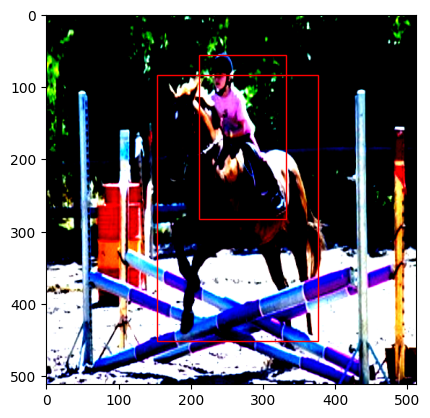

In [3]:
import matplotlib.pyplot as plt
import torch
from typing import Tuple


def plot_data(
    img: torch.Tensor,
    bboxes: torch.Tensor,
    scores: torch.Tensor = None,
    threshold: float = 0.5,
):
    img = img.permute(1, 2, 0)

    if scores is not None:
        bboxes = bboxes[scores >= threshold]
    plt.imshow(img)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=1
        )
        plt.gca().add_patch(rect)
    plt.show()


for batch in dtm.train_dataloader():
    img, bboxes, labels = batch
    plot_data(img[0], bboxes[0])
    break


In [4]:
from src.models.centernet_module import CenterNet
from src.models.components.resnet import PoseResNet, BasicBlock

model = CenterNet(
    PoseResNet(
        BasicBlock,
        64,
        [2, 2, 2, 2],
        num_classes=21,
    ),
    optimizer=torch.optim.Adam,
    scheduler=torch.optim.lr_scheduler.MultiStepLR,
)


In [5]:
def load_from_checkpoint(ckpt_path: str):
    ckpt = torch.load(ckpt_path)["state_dict"]
    model.load_state_dict(ckpt)

    return model


model = load_from_checkpoint("./last.ckpt")


In [6]:
pboxes, pscores, plabels = model.predict(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


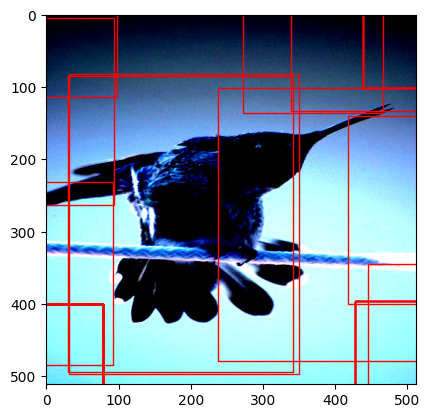

In [23]:
idx = 1
plot_data(img[idx], pboxes[idx], pscores[idx], threshold=0.01)


In [24]:
from src.datamodules.voc_datamodule import VOC_CLASSES

[VOC_CLASSES[i] for i in plabels[idx]]


['person',
 'person',
 'person',
 'cat',
 'pottedplant',
 'cat',
 'pottedplant',
 'person',
 'car',
 'cat',
 'pottedplant',
 'person',
 'diningtable',
 'horse',
 'bicycle',
 'cow',
 'bicycle',
 'bird',
 'bottle',
 'boat',
 'bird',
 'bus',
 'bottle',
 'train',
 'person',
 'person',
 'car',
 'cat',
 'train',
 'person',
 'sofa',
 'person',
 'person',
 'cow',
 'person',
 'person']

In [8]:
keypoints, offsets, sizes = model._get_object_params(bboxes, downsample=0.25)


In [9]:
keypoints


[tensor([[66, 66],
         [67, 42]], dtype=torch.int32),
 tensor([[60, 69]], dtype=torch.int32),
 tensor([[96, 68],
         [48, 89],
         [26, 89]], dtype=torch.int32),
 tensor([[117,  70],
         [ 57,  82],
         [ 43,  76],
         [ 63,  68]], dtype=torch.int32)]

In [10]:
heatmaps = model._produce_gt_heatmap(keypoints, labels, model.num_classes, 128, 128)


In [11]:
heatmaps[0].shape


torch.Size([21, 128, 128])

In [12]:
offsets_map, sizes_map, masks = model._produce_gt_offset_and_size(
    keypoints, offsets, sizes, 128, 128
)


In [13]:
from src.utils import decode

dec_bboxes, scores, classes = decode(heatmaps, offsets_map, sizes_map, 0.25, top_k=100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


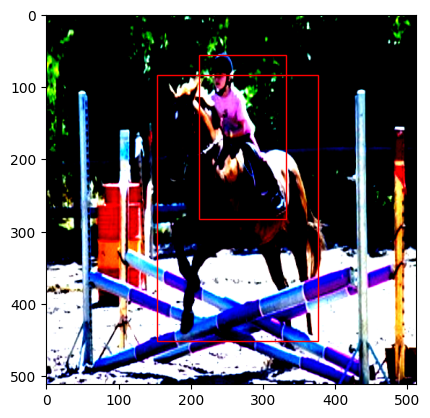

In [14]:
plot_data(img[0], dec_bboxes[0])


In [15]:
classes[0]

tensor([13, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0])